# Notebook 6: Trying with last periodicity of 1,2,7,14

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


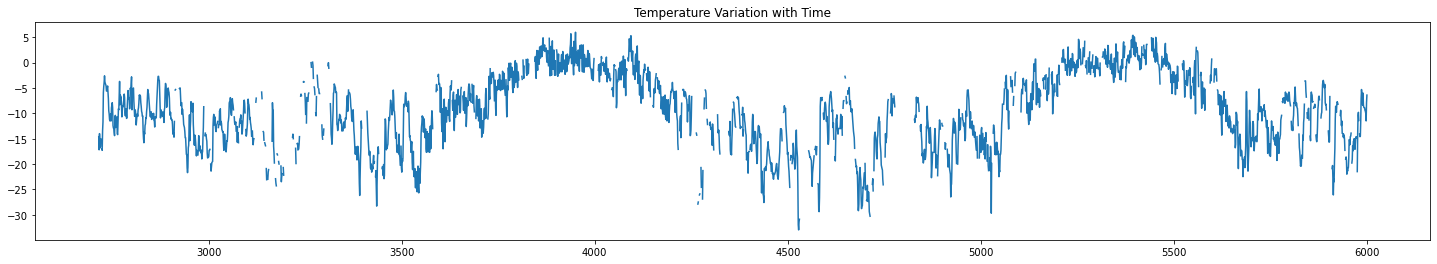

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=[]):
    df = dataframe.copy()
    for lag in prev_n_days:
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=[1,2,7,14])

In [11]:
y

array([ -2.6,  -3.8,  -4.1, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[ -3.9],
        [ -4.7],
        [-17. ],
        [-17.2]],

       [[ -2.6],
        [ -3.9],
        [-17.3],
        [-14. ]],

       [[ -3.8],
        [ -2.6],
        [-13.4],
        [-15.5]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -8.4],
        [-11.5]],

       [[-11.5],
        [-10. ],
        [ -8.8],
        [ -7.1]],

       [[ -7.9],
        [-11.5],
        [ -8.9],
        [ -5.3]]])

In [13]:
y.shape

(1764,)

# Temporal splitting

In [14]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

1234 1499


# Standardization

In [15]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [17]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs5',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [18]:
model1 = Sequential()
model1.add(InputLayer((4,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model5/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
38/39 [============================>.] - ETA: 0s - loss: 126.8595 - root_mean_squared_error: 11.2632

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 18s 341ms/step - loss: 126.4226 - root_mean_squared_error: 11.2438 - val_loss: 26.7893 - val_root_mean_squared_error: 5.1758
Epoch 2/50
38/39 [============================>.] - ETA: 0s - loss: 66.2843 - root_mean_squared_error: 8.1415

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 327ms/step - loss: 65.8185 - root_mean_squared_error: 8.1129 - val_loss: 17.3706 - val_root_mean_squared_error: 4.1678
Epoch 3/50
38/39 [============================>.] - ETA: 0s - loss: 35.7436 - root_mean_squared_error: 5.9786

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 318ms/step - loss: 35.7025 - root_mean_squared_error: 5.9752 - val_loss: 13.2357 - val_root_mean_squared_error: 3.6381
Epoch 4/50
38/39 [============================>.] - ETA: 0s - loss: 24.6809 - root_mean_squared_error: 4.9680

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 11s 298ms/step - loss: 24.5978 - root_mean_squared_error: 4.9596 - val_loss: 11.1230 - val_root_mean_squared_error: 3.3351
Epoch 5/50
30/39 [======================>.......] - ETA: 0s - loss: 18.4202 - root_mean_squared_error: 4.2919

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 15s 399ms/step - loss: 18.3436 - root_mean_squared_error: 4.2829 - val_loss: 9.4300 - val_root_mean_squared_error: 3.0708
Epoch 6/50
39/39 [==============================] - ETA: 0s - loss: 12.3477 - root_mean_squared_error: 3.5139

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 329ms/step - loss: 12.3477 - root_mean_squared_error: 3.5139 - val_loss: 7.4066 - val_root_mean_squared_error: 2.7215
Epoch 7/50
35/39 [=========================>....] - ETA: 0s - loss: 6.8496 - root_mean_squared_error: 2.6172

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 325ms/step - loss: 6.7138 - root_mean_squared_error: 2.5911 - val_loss: 6.9849 - val_root_mean_squared_error: 2.6429
Epoch 8/50
36/39 [==========================>...] - ETA: 0s - loss: 6.0992 - root_mean_squared_error: 2.4697

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 332ms/step - loss: 6.0066 - root_mean_squared_error: 2.4508 - val_loss: 6.7780 - val_root_mean_squared_error: 2.6035
Epoch 9/50
31/39 [======================>.......] - ETA: 0s - loss: 5.1080 - root_mean_squared_error: 2.2601

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 16s 422ms/step - loss: 5.0178 - root_mean_squared_error: 2.2400 - val_loss: 6.3675 - val_root_mean_squared_error: 2.5234
Epoch 10/50
39/39 [==============================] - 0s 8ms/step - loss: 4.7821 - root_mean_squared_error: 2.1868 - val_loss: 6.3800 - val_root_mean_squared_error: 2.5259
Epoch 11/50
38/39 [============================>.] - ETA: 0s - loss: 4.7075 - root_mean_squared_error: 2.1697

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 11s 300ms/step - loss: 4.7040 - root_mean_squared_error: 2.1689 - val_loss: 6.1895 - val_root_mean_squared_error: 2.4879
Epoch 12/50
37/39 [===========================>..] - ETA: 0s - loss: 4.5630 - root_mean_squared_error: 2.1361

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 14s 362ms/step - loss: 4.5787 - root_mean_squared_error: 2.1398 - val_loss: 6.1451 - val_root_mean_squared_error: 2.4789
Epoch 13/50
39/39 [==============================] - ETA: 0s - loss: 4.7519 - root_mean_squared_error: 2.1799

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 330ms/step - loss: 4.7519 - root_mean_squared_error: 2.1799 - val_loss: 6.0986 - val_root_mean_squared_error: 2.4695
Epoch 14/50
38/39 [============================>.] - ETA: 0s - loss: 4.3667 - root_mean_squared_error: 2.0897

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 16s 426ms/step - loss: 4.3322 - root_mean_squared_error: 2.0814 - val_loss: 6.0919 - val_root_mean_squared_error: 2.4682
Epoch 15/50
36/39 [==========================>...] - ETA: 0s - loss: 4.1931 - root_mean_squared_error: 2.0477

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 15s 382ms/step - loss: 4.2447 - root_mean_squared_error: 2.0603 - val_loss: 6.0518 - val_root_mean_squared_error: 2.4600
Epoch 16/50
31/39 [======================>.......] - ETA: 0s - loss: 4.1768 - root_mean_squared_error: 2.0437

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 11s 294ms/step - loss: 4.2863 - root_mean_squared_error: 2.0703 - val_loss: 5.9841 - val_root_mean_squared_error: 2.4463
Epoch 17/50
34/39 [=========================>....] - ETA: 0s - loss: 4.2118 - root_mean_squared_error: 2.0523

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 11s 294ms/step - loss: 4.1757 - root_mean_squared_error: 2.0435 - val_loss: 5.9352 - val_root_mean_squared_error: 2.4362
Epoch 18/50
39/39 [==============================] - 0s 10ms/step - loss: 4.0952 - root_mean_squared_error: 2.0236 - val_loss: 6.0560 - val_root_mean_squared_error: 2.4609
Epoch 19/50
37/39 [===========================>..] - ETA: 0s - loss: 4.1209 - root_mean_squared_error: 2.0300

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 304ms/step - loss: 4.1028 - root_mean_squared_error: 2.0255 - val_loss: 5.7070 - val_root_mean_squared_error: 2.3889
Epoch 20/50
31/39 [======================>.......] - ETA: 0s - loss: 4.0176 - root_mean_squared_error: 2.0044

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 302ms/step - loss: 4.0530 - root_mean_squared_error: 2.0132 - val_loss: 5.6838 - val_root_mean_squared_error: 2.3841
Epoch 21/50
39/39 [==============================] - 0s 9ms/step - loss: 4.0458 - root_mean_squared_error: 2.0114 - val_loss: 5.8421 - val_root_mean_squared_error: 2.4170
Epoch 22/50
37/39 [===========================>..] - ETA: 0s - loss: 3.9086 - root_mean_squared_error: 1.9770

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 332ms/step - loss: 3.8808 - root_mean_squared_error: 1.9700 - val_loss: 5.6284 - val_root_mean_squared_error: 2.3724
Epoch 23/50
33/39 [========================>.....] - ETA: 0s - loss: 3.6035 - root_mean_squared_error: 1.8983

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 326ms/step - loss: 3.7161 - root_mean_squared_error: 1.9277 - val_loss: 5.5752 - val_root_mean_squared_error: 2.3612
Epoch 24/50
39/39 [==============================] - 0s 7ms/step - loss: 3.7340 - root_mean_squared_error: 1.9324 - val_loss: 5.6965 - val_root_mean_squared_error: 2.3867
Epoch 25/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7147 - root_mean_squared_error: 1.9274 - val_loss: 5.7035 - val_root_mean_squared_error: 2.3882
Epoch 26/50
39/39 [==============================] - 0s 7ms/step - loss: 3.9820 - root_mean_squared_error: 1.9955 - val_loss: 5.7530 - val_root_mean_squared_error: 2.3986
Epoch 27/50
39/39 [==============================] - 0s 11ms/step - loss: 3.8884 - root_mean_squared_error: 1.9719 - val_loss: 5.6710 - val_root_mean_squared_error: 2.3814
Epoch 28/50
31/39 [======================>.......] - ETA: 0s - loss: 3.7217 - root_mean_squared_error: 1.9292

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 352ms/step - loss: 3.7915 - root_mean_squared_error: 1.9472 - val_loss: 5.5122 - val_root_mean_squared_error: 2.3478
Epoch 29/50
33/39 [========================>.....] - ETA: 0s - loss: 3.8734 - root_mean_squared_error: 1.9681

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 335ms/step - loss: 3.7645 - root_mean_squared_error: 1.9402 - val_loss: 5.5055 - val_root_mean_squared_error: 2.3464
Epoch 30/50
37/39 [===========================>..] - ETA: 0s - loss: 3.8698 - root_mean_squared_error: 1.9672

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 334ms/step - loss: 3.8516 - root_mean_squared_error: 1.9626 - val_loss: 5.4577 - val_root_mean_squared_error: 2.3362
Epoch 31/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7110 - root_mean_squared_error: 1.9264 - val_loss: 5.5184 - val_root_mean_squared_error: 2.3491
Epoch 32/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7172 - root_mean_squared_error: 1.9280 - val_loss: 5.5113 - val_root_mean_squared_error: 2.3476
Epoch 33/50
39/39 [==============================] - 0s 8ms/step - loss: 3.6553 - root_mean_squared_error: 1.9119 - val_loss: 5.4740 - val_root_mean_squared_error: 2.3397
Epoch 34/50
39/39 [==============================] - 1s 18ms/step - loss: 3.6661 - root_mean_squared_error: 1.9147 - val_loss: 5.5029 - val_root_mean_squared_error: 2.3458
Epoch 35/50
38/39 [============================>.] - ETA: 0s - loss: 3.6504 - root_mean_squared_error: 1.9106

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 321ms/step - loss: 3.6575 - root_mean_squared_error: 1.9125 - val_loss: 5.4217 - val_root_mean_squared_error: 2.3285
Epoch 36/50
31/39 [======================>.......] - ETA: 0s - loss: 3.5906 - root_mean_squared_error: 1.8949

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 13s 338ms/step - loss: 3.6025 - root_mean_squared_error: 1.8980 - val_loss: 5.3776 - val_root_mean_squared_error: 2.3190
Epoch 37/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7669 - root_mean_squared_error: 1.9409 - val_loss: 5.4325 - val_root_mean_squared_error: 2.3308
Epoch 38/50
39/39 [==============================] - 0s 8ms/step - loss: 3.6301 - root_mean_squared_error: 1.9053 - val_loss: 5.4093 - val_root_mean_squared_error: 2.3258
Epoch 39/50
39/39 [==============================] - 0s 8ms/step - loss: 3.6434 - root_mean_squared_error: 1.9088 - val_loss: 5.4109 - val_root_mean_squared_error: 2.3261
Epoch 40/50
39/39 [==============================] - 0s 11ms/step - loss: 3.6684 - root_mean_squared_error: 1.9153 - val_loss: 5.3984 - val_root_mean_squared_error: 2.3234
Epoch 41/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7878 - root_mean_squared_error: 1.9462 - val_loss: 5.4617 - val_root_mean_squa

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


39/39 [==============================] - 12s 320ms/step - loss: 3.5912 - root_mean_squared_error: 1.8951 - val_loss: 5.3465 - val_root_mean_squared_error: 2.3123
Epoch 47/50
39/39 [==============================] - 0s 8ms/step - loss: 3.7761 - root_mean_squared_error: 1.9432 - val_loss: 5.4348 - val_root_mean_squared_error: 2.3313
Epoch 48/50
39/39 [==============================] - 0s 8ms/step - loss: 3.6609 - root_mean_squared_error: 1.9133 - val_loss: 5.4999 - val_root_mean_squared_error: 2.3452
Epoch 49/50
39/39 [==============================] - 1s 14ms/step - loss: 3.7407 - root_mean_squared_error: 1.9341 - val_loss: 5.4739 - val_root_mean_squared_error: 2.3396
Epoch 50/50
39/39 [==============================] - 0s 8ms/step - loss: 3.6157 - root_mean_squared_error: 1.9015 - val_loss: 5.3483 - val_root_mean_squared_error: 2.3126


In [21]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [22]:
from tensorflow.keras.models import load_model
model1 = load_model('model5/')

In [23]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

39/39 [==============================] - 0s 4ms/step


In [24]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 2.970199192970973'}>

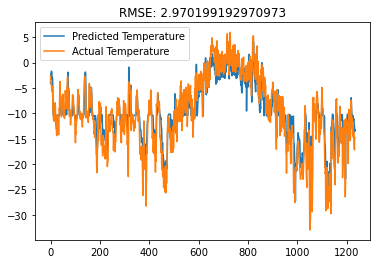

In [25]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.095245883116993'}>

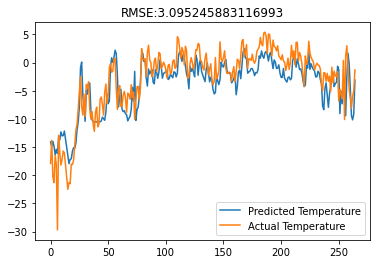

In [26]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:3.0207391667681804'}>

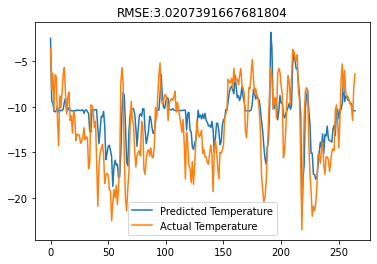

In [27]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [28]:
y.shape

(1764,)